In [30]:
import os
import certifi
import arcpy

# set default gdal and ertifi envs (non-dev)
try:
    install_dir = arcpy.GetInstallInfo().get('InstallDir')  # get arcgis install dir
    os.environ['GDAL_DATA'] = os.path.join(install_dir, 'Resources\pedata\gdaldata')  # join to gdal install
    os.environ.setdefault("CURL_CA_BUNDLE", certifi.where())  # set certifi
except:
    arcpy.AddError('Could not get install directory for ArcGIS Pro or set certifi.')
    raise

In [31]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': 'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# safe imports
import sys                  # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    from osgeo import gdal
    from osgeo import ogr
    from osgeo import osr
    import tempfile
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    from odc import stac
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import nrt, cog_odc, cog
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise

In [32]:
import matplotlib.pyplot as plt

In [4]:
# need button to create shapefile with relevent attributes
# set a folder
# create a shapefile of polygons
# need a id field, out netcdf, platform, start/end monitor date, other

### Create monitoring areas

In [36]:
#out_folder = r'C:\Users\Lewis\Desktop\nrt_projects'
#out_filename = 'ophthalmia_monitoring'

# create a new nrt project
#arcpy.NRT_Create_Project_toolbox(out_folder, out_filename)

### Make monitoring areas

In [4]:
# this is up to user using usual arcgis pro tools?

### Begin monitoring of areas

In [33]:
# perform sync
in_feat = r'C:\Users\Lewis\Desktop\nrt_projects\ophthalmia_monitoring.gdb\monitoring_areas'

# temp inputs
in_fmask_flags = 'Valid;Snow;Water'
in_max_cloud = 0
in_veg_idx = 'MAVI'

In [74]:
#ds_summary = execute(in_feat=r'C:\Users\Lewis\Desktop\nrt_projects\ophthalmia_monitoring.gdb\monitoring_areas',
                      #in_fmask_flags='Valid;Snow;Water',
                      #in_max_cloud=0, 
                      #in_veg_idx='MAVI', 
                      #ewmacd_method='static',
                      #keep_running=True,
                      #time_interval=30)  # 43200

### Traffic light Working

In [35]:
from math import ceil
import numpy as np
from scipy import linalg

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    
    yest = np.zeros(n)
    delta = np.ones(n)
    
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

In [87]:
%matplotlib inline

ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A01.nc")  # big impact 2007 ophtha dam area
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A02.nc")  # big impact 2007 ophtha dam area, but training done 2013, so recovery is shown
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A03.nc")  # near impact 2007 ophtha dam area, less impact in 2007
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A04.nc")  # open shrubland with wo euc? training period bad
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A05.nc")  # mulga area on road side? training period bad
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A06.nc")  # euc vic east yandi. gradual increasing... odd result? try train period
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A07.nc")  # yandi discharge south veg... good, but change in training period?
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A08.nc")   # yandi elephatn graveyard. good - 2007 decline

### Veg summary

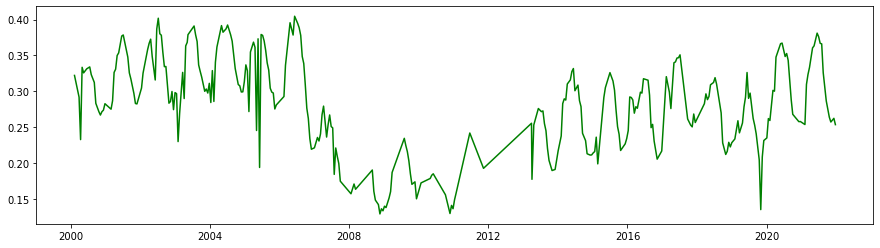

In [88]:
vec_summary = ds_change['summary'].median(['x', 'y']).data
fig = plt.figure(figsize=(15, 4))
plt.plot(ds_change['time'].data, vec_summary, color='green')
plt.show()

### Static change

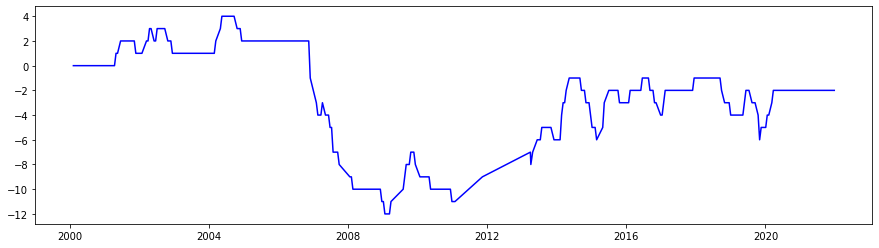

In [89]:
vec_static = ds_change['static'].median(['x', 'y']).data
fig = plt.figure(figsize=(15, 4))
plt.plot(ds_change['time'].data, vec_static, color='blue')
plt.show()

### Store change 


In [90]:
# we need to store changes to a cube, because adding new images fluctuates it
# also, persistence should be low, 0.25 works ok?
# see ewmacd_arcgis python project for working

### Lowess smooth

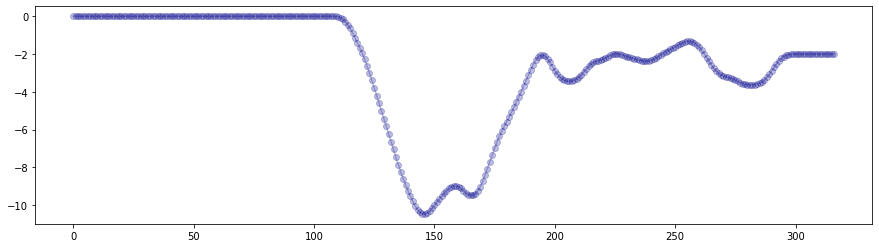

In [91]:
# smooth & plot
vec_static_smooth = ds_change['static'].median(['x', 'y']).data
#vec_static_smooth = ds_change['static'].isel(time=slice(0, 128)).median(['x', 'y']).data

vec_static_smooth = np.where(vec_static_smooth > 0, 0, vec_static_smooth) # remove positives

x = np.arange(0, len(vec_static_smooth))
y = vec_static_smooth
yest = lowess_ag(x, y, f=0.075, iter=1)  # f is smooth %, iter is ?

fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.show()

In [92]:
# based on nelson rules (https://en.wikipedia.org/wiki/Nelson_rules)

### Rule 1: points outside 3 stdvs

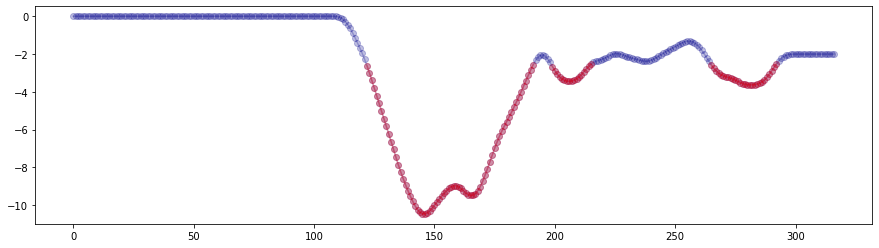

In [93]:
# set the max stdv threshold, anything below this is flagged
stdv_threshold = -2.5

vec_r1 = np.where(yest < stdv_threshold, yest, np.nan)

fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.plot(vec_r1, color='red', marker='o', alpha=0.25)
plt.show()

### Rule 2: consequitive samples all on one side

In [13]:
# based on nelson. we dont need for static

### Rule 3: consequtive declines

In [94]:
# incrementally count negs
def count_consequtive_negs(arr):
    neg_cons = np.array([])
    
    for i, v in enumerate(arr):
        if i > 0 and v > 0:
            v += neg_cons[i - 1]
        neg_cons = np.append(neg_cons, v)
    
    return neg_cons

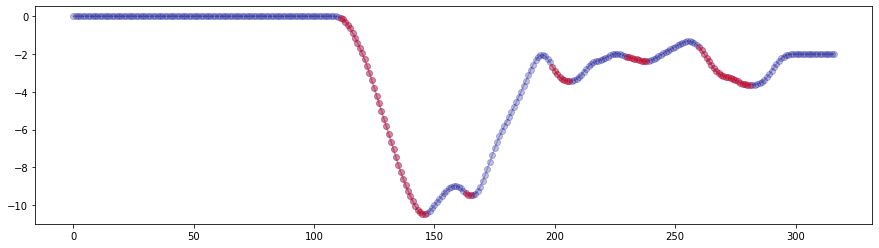

In [110]:
# set number of consequitve declines required for flag
num_declines = 4  # think about this in days. e.g. when 6 days constant neg, flag on fourth day. based on nelson

# calc diffs, make mask of 1s and 0s
diffs = np.diff(yest, prepend=yest[0])  # get diffs and prepend val to start
diffs = np.where(diffs < 0, 1.0, 0.0)  # convert positives to 0

# calc consequitve  negs
cons_negs = count_consequtive_negs(diffs)

# remove any consequitves under num_declines
vec_r3 = np.where(cons_negs >= num_declines, cons_negs, np.nan)

fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.plot(np.where(~np.isnan(vec_r3), yest, np.nan), color='red', marker='o', alpha=0.25)
plt.show()

### Rule 4: some samples jumped zone(s)

In [108]:
num_samples_in_new_zone = 3
num_zone_jumps = 2

In [79]:
yest[-15:] = np.array([-3., -5., -5., -6., -6., -6., -6., -6., -6., -6., -6., -6., -6., -7., -8.])

In [82]:
vec_r4 = yest.copy()
vec_r4[-15:] = np.array([-3., -5., -5., -999., -999., -999., -999., -999., -999., -999., -999., -999., -999., -7., -8.])
vec_r4 = np.where(vec_r4 == -999, -6, np.nan)

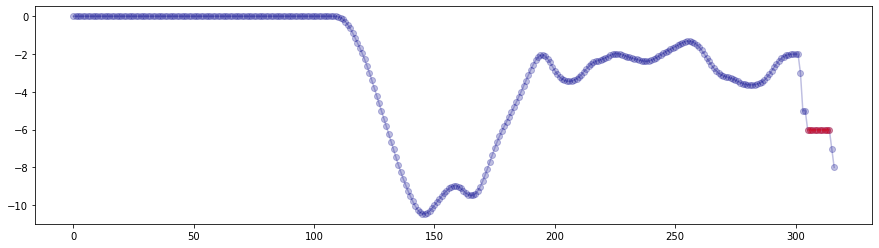

In [85]:
fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.plot(np.where(~np.isnan(vec_r4), yest, np.nan), color='red', marker='o', alpha=0.25)
plt.show()

### Combine rules

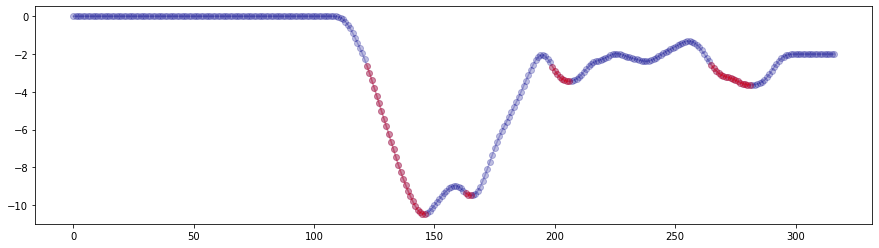

In [109]:
mask = np.where(~np.isnan(vec_r1), vec_r3, np.nan)

fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.plot(np.where(~np.isnan(mask), yest, np.nan), color='red', marker='o', alpha=0.25)
plt.show()

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan,  4.,  5.,  6., nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

### Testing

In [ ]:
# zone1 (z1) <= 2 stdvs
# zone2 (z2) > 2 and <= 4 
# zone3 (z3) > 4 and <= 6 
# zone4 (z4) > 6 and <= 8
# zone5 (z5) > 8 and <= 10
# zone6 (z6) > 10 and <= 12
# zone7 (z7) > 12 and <= 14
# zone8 (z8) > 14

In [58]:
-2 < -1

True

In [16]:
z1 = np.where(yest <= -2, vec_r3, np.nan)
z2 = np.where((yest < -2) & (yest >= -4), vec_r3, np.nan)
z3 = np.where((yest < -4) & (yest >= -6), vec_r3, np.nan)
z4 = np.where((yest < -6) & (yest >= -8), vec_r3, np.nan)
z5 = np.where((yest < -10) & (yest >= -12), vec_r3, np.nan)
z6 = np.where((yest < -12) & (yest >= -14), vec_r3, np.nan)
z7 = np.where((yest < -14) & (yest >= -16), vec_r3, np.nan)
z8 = np.where((yest < -16) & (yest >= -18), vec_r3, np.nan)

In [22]:
for i in range(yest):
    print(yest[:-316])

TypeError: only integer scalar arrays can be converted to a scalar index

In [21]:
counter = 0
for i in range((len(yest) - 1) * -1, 0): 
    
    num_declines = 6  # think about this in days. e.g. when 6 days constant neg, flag on fourth day. based on nelson
    diffs = np.diff(yest, prepend=yest[0])  # get diffs and prepend val to start
    diffs = np.where(diffs < 0, 1.0, 0.0)  # convert positives to 0
    cons_negs = count_consequtive_negs(diffs)
    vec_r3 = np.where(cons_negs >= num_declines, cons_negs, np.nan)
    
    z1 = np.where(yest <= -2, vec_r3, np.nan)
    z2 = np.where((yest < -2) & (yest >= -4), vec_r3, np.nan)
    z3 = np.where((yest < -4) & (yest >= -6), vec_r3, np.nan)
    z4 = np.where((yest < -6) & (yest >= -8), vec_r3, np.nan)
    z5 = np.where((yest < -10) & (yest >= -12), vec_r3, np.nan)
    z6 = np.where((yest < -12) & (yest >= -14), vec_r3, np.nan)
    z7 = np.where((yest < -14) & (yest >= -16), vec_r3, np.nan)
    z8 = np.where((yest < -16) & (yest >= -18), vec_r3, np.nan)
    
    # z1
    #if ~np.isnan(z1[:i][-1]):
        #print('alarm! entered zone 1. idx: {}. val: {}'.format(counter, z1[:i][-1]))
    
    #if ~np.isnan(z2[:i][-1]):
        #print('alarm! entered zone 2. idx: {}. val: {}'.format(counter, z2[:i][-1]))
        
    #if ~np.isnan(z3[:i][-1]):
        #print('alarm! entered zone 3. idx: {}. val: {}'.format(counter, z3[:i][-1]))   
        
    #if ~np.isnan(z4[:i][-1]):
        #print('alarm! entered zone 4. idx: {}. val: {}'.format(counter, z4[:i][-1]))  
        
    if ~np.isnan(z5[:i][-1]):
        print('alarm! entered zone 5. idx: {}. val: {}'.format(counter, z5[:i][-1])) 
        
    #if ~np.isnan(z6[:i][-1]):
        #print('alarm! entered zone 6. idx: {}. val: {}'.format(counter, z6[:i][-1])) 
        
    #if ~np.isnan(z7[:i][-1]):
        #print('alarm! entered zone 7. idx: {}. val: {}'.format(counter, z7[:i][-1])) 
        
    #if ~np.isnan(z8[:i][-1]):
        #print('alarm! entered zone 8. idx: {}. val: {}'.format(counter, z8[:i][-1])) 
        
    counter += 1

    

alarm! entered zone 5. idx: 142. val: 35.0
alarm! entered zone 5. idx: 143. val: 36.0
alarm! entered zone 5. idx: 144. val: 37.0
alarm! entered zone 5. idx: 145. val: 38.0
alarm! entered zone 5. idx: 146. val: 39.0


### Testing incrementing conseq counter

In [111]:
def get_zone(value):
    
    # zone 0 - stable
    if value < 0 and value >= -1:
        #print('Zone 0: between 0 and -1.')
        return 0
    
    # zone 1 - between -1, -3
    elif value < -1 and value >= -3:
        #print('Zone 1: between -1 and -3.')
        return 1
    
    # zone 2 - between -3, -5
    elif value < -3 and value >= -5:
        #print('Zone 2: between -3 and -5.')
        return 2
    
    # zone 3 - between -5, -7
    elif value < -5 and value >= -7:
        #print('Zone 3: between -5 and -7.')
        return 3
    
    # zone 4 - between -7, -9
    elif value < -7 and value >= -9:
        #print('Zone 4: between -7 and -9.')
        return 4
    
    # zone 4 - less than -9
    elif value < -9:
        #print('Zone 5: less than -9.')
        return 5
    
    # no zone
    else:
        #print('No zone.')
        return

In [112]:
# set up some globals
num_conseq = 4
zone_flagged = None

5


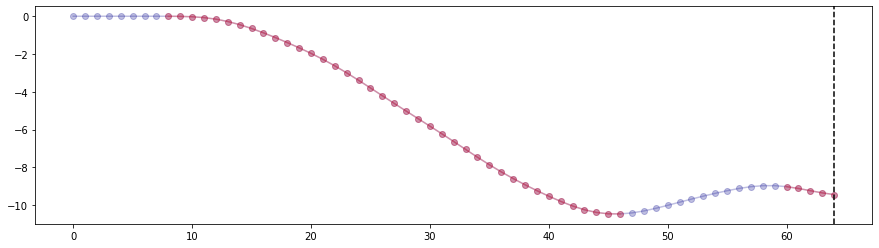

In [113]:
da = yest[100:165]

# calc diffs, make mask of 1s and 0s
diffs = np.diff(da, prepend=da[0])  # get diffs and prepend val to start
diffs = np.where(diffs < 0, 1.0, 0.0)  # convert positives to 0

# calc consequitve  negs
cons_negs = count_consequtive_negs(diffs)

# remove any consequitves under num_declines
vec = np.where(cons_negs >= 1, cons_negs, np.nan)

# get latest element
latest_change_dev = da[-1]
latest_zone = get_zone(da[-1])
latest_conseq_decline = vec[-1]

# plot
fig = plt.figure(figsize=(15, 4))
plt.plot(da, color='darkblue', marker='o', alpha=0.25)
plt.plot(np.where(~np.isnan(vec), da, np.nan), color='red', marker='o', alpha=0.25)

# detect early decline
if latest_zone == 0 and latest_conseq_decline > num_conseq:
    if zone_flagged != 0:
        plt.axvline(x=len(da) - 1, color='green', linestyle='--')
        zone_flagged = 0
        
elif latest_zone == 1 and latest_conseq_decline > num_conseq:
    if zone_flagged != 1:
        plt.axvline(x=len(da) - 1, color='yellow', linestyle='--')
        zone_flagged = 1
        
elif latest_zone == 2 and latest_conseq_decline > num_conseq:
    if zone_flagged != 2:
        plt.axvline(x=len(da) - 1, color='orange', linestyle='--')
        zone_flagged = 2
        
elif latest_zone == 3 and latest_conseq_decline > num_conseq:
    if zone_flagged != 3:
        plt.axvline(x=len(da) - 1, color='red', linestyle='--')
        zone_flagged = 3

elif latest_zone == 4 and latest_conseq_decline > num_conseq:
    if zone_flagged != 4:
        plt.axvline(x=len(da) - 1, color='darkred', linestyle='--')
        zone_flagged = 4
        
elif latest_zone == 5 and latest_conseq_decline > num_conseq:
    if zone_flagged != 5:
        plt.axvline(x=len(da) - 1, color='black', linestyle='--')
        zone_flagged = 5
        
# notify of flag
print(zone_flagged)
        
# reset flag if we leave consequitve
if np.isnan(latest_conseq_decline): 
    zone_flagged = None

plt.show()

### Bringing it all together

In [29]:
-3 <= -2

True

In [268]:
def determine_flag(arr, max_consequitive_declines=4):
    """
    """
    
    # checks
    #
    
    # notify
    #
    
    # calc differences between each value, make binary mask
    diffs = np.diff(arr, prepend=arr[0])      # get diffs, prepend val to start
    diffs = np.where(diffs < 0, 1.0, 0.0)   # convert positives to 0
    
    # calculate consequitve  negs
    cons_negs = count_consequtive_negs(diffs)

    # set any non-consequitve values to nan
    vec = np.where(cons_negs >= 1, cons_negs, np.nan)
    
    # extract latest change value, zone and consequitve value
    new_change_dev = arr[-1]
    new_zone = get_zone(arr[-1])
    new_conseq_decline = vec[-1]
    
    # notify
    print('Latest deviation: {}, in zone: {}, consequitive: {}.'.format(new_change_dev, 
                                                                        new_zone, 
                                                                        new_conseq_decline))
    
    # plot (temporary)
    fig = plt.figure(figsize=(15, 4))
    plt.plot(arr, color='darkblue', marker='o', alpha=0.25)
    plt.plot(np.where(~np.isnan(vec), arr, np.nan), color='red', marker='o', alpha=0.25)
    
    
    # classify latest observation
    if new_zone == 0 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='yellow', linestyle='--')

    elif new_zone == 1 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='orange', linestyle='--')

    elif new_zone == 2 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='orangered', linestyle='--')

    elif new_zone == 3 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='red', linestyle='--')

    elif new_zone == 4 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='firebrick', linestyle='--')

    elif new_zone == 5 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='saddlebrown', linestyle='--')
    
    # show plot
    #plt.show()
    fn = datetime.now().strftime("%H:%M:%S:%f").replace(':', '')
    fn = os.path.join(r'C:\Users\Lewis\Desktop\output', fn + '.jpg')
    plt.savefig(fn)
    plt.close()
    
    # plot empty line
    #print()

In [269]:
for i in range(0, len(yest)):
    try:
        da = yest[0:i]
        determine_flag(arr=da)
    except:
        print('issue')

issue
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in

Latest deviation: -1.3475142136048213, in zone: 1, consequitive: nan.
Latest deviation: -1.3178327966057939, in zone: 1, consequitive: nan.
Latest deviation: -1.3157021754535672, in zone: 1, consequitive: nan.
Latest deviation: -1.3444101234718326, in zone: 1, consequitive: 1.0.
Latest deviation: -1.4072853697975525, in zone: 1, consequitive: 2.0.
Latest deviation: -1.5059168301118255, in zone: 1, consequitive: 3.0.
Latest deviation: -1.6389151440275214, in zone: 1, consequitive: 4.0.
Latest deviation: -1.8017919103757478, in zone: 1, consequitive: 5.0.
Latest deviation: -1.9875615110084297, in zone: 1, consequitive: 6.0.
Latest deviation: -2.187210730513023, in zone: 1, consequitive: 7.0.
Latest deviation: -2.389164287719616, in zone: 1, consequitive: 8.0.
Latest deviation: -2.581466096928459, in zone: 1, consequitive: 9.0.
Latest deviation: -2.753186892860924, in zone: 1, consequitive: 10.0.
Latest deviation: -2.8967731738997458, in zone: 1, consequitive: 11.0.
Latest deviation: -3.0

### Rates

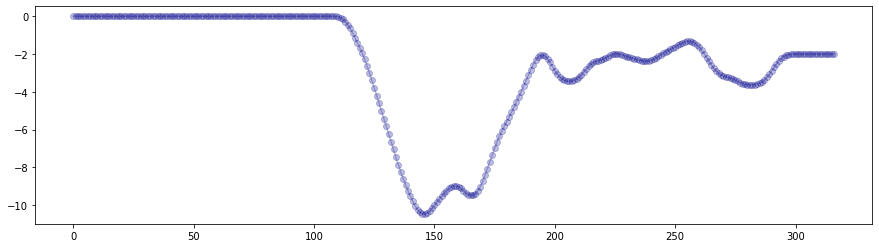

In [138]:
fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.show()

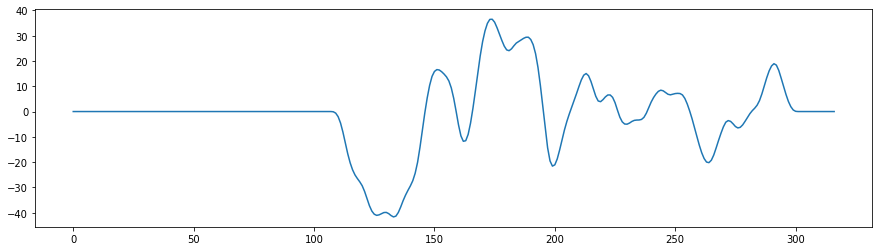

In [343]:
# (value_new - value_old) / (time_new - time_old)

yest_diffs = np.diff(yest)
yest_diffs = np.insert(yest_diffs, 0, 0)

dts = np.arange(0, len(yest))
time_diffs = np.diff(dts)
time_diffs = np.insert(time_diffs, 0, 1)

rate_of_change = (yest_diffs / time_diffs) * 100

fig = plt.figure(figsize=(15, 4))
plt.plot(rate_of_change)
plt.show()

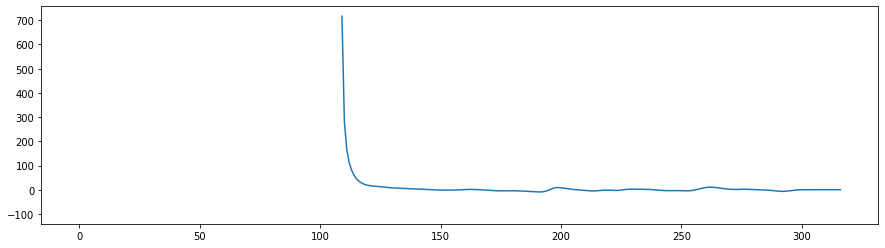

In [271]:
rater = []
for i in range(0, len(yest)):
    try:
        rater.append(((yest[i] - yest[i -1]) / yest[i -1]) * 100)
        
    except:
        rater.append(np.nan)
        
fig = plt.figure(figsize=(15, 4))
plt.plot(rater)
plt.show()

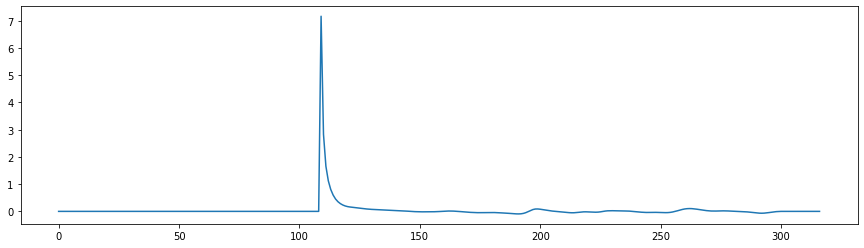

In [272]:
import pandas as pd
df = pd.DataFrame(yest, columns = ['deviation'])
df = df.pct_change()
change = df.to_numpy().flatten()
change = np.where(np.isnan(change), 0, change)
change = np.where(np.isinf(change), 0, change)

fig = plt.figure(figsize=(15, 4))
plt.plot(change)
plt.show()

### EWMA

In [190]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

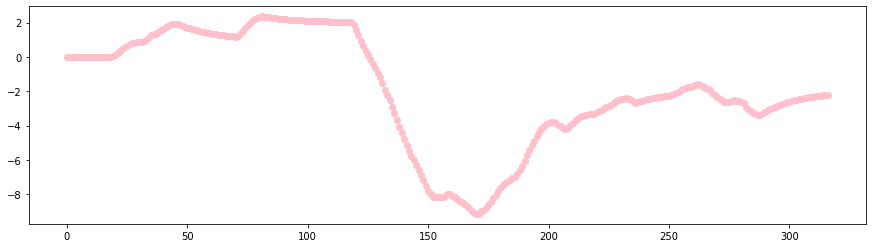

In [200]:
vec_ewma = numpy_ewma_vectorized_v2(data=vec_static_smooth, window=30)

fig = plt.figure(figsize=(15, 4))
plt.plot(vec_ewma, color='pink', marker='o')
plt.show()

### CUMSUM AVG

D66140B0-0277-45FF-AE18-A787BE3D4AAF:1: RuntimeWarning: invalid value encountered in true_divide


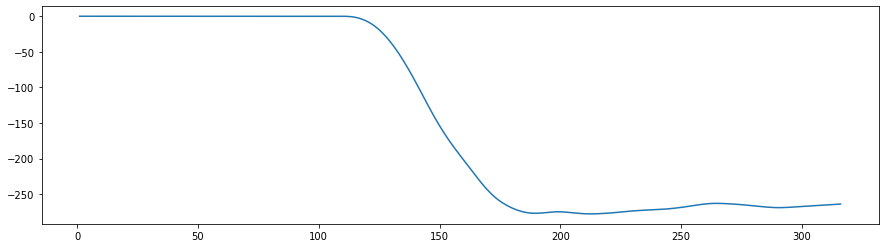

In [188]:
cumsumavg = np.cumsum(yest) / np.arange(0, len(yest)) * 100
fig = plt.figure(figsize=(15, 4))
plt.plot(cumsumavg)
plt.show()

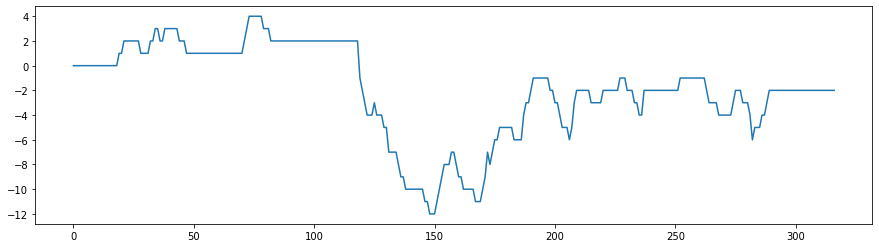

In [ ]:
# https://en.wikipedia.org/wiki/Western_Electric_rules

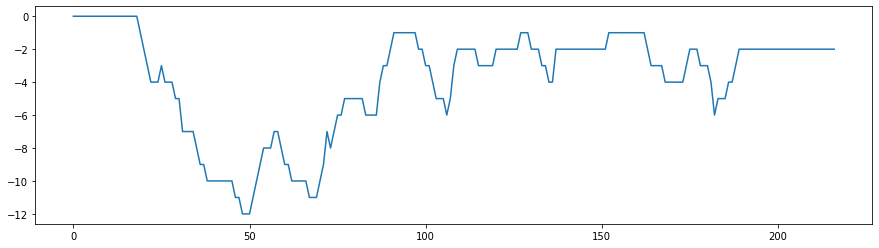

In [49]:
# remove positives
vec_static = vec_static[vec_static <= 0]

fig = plt.figure(figsize=(15, 4))
plt.plot(vec_static)
plt.show()

In [41]:
#vec_dynamic = ds_change['dynamic'].median(['x', 'y']).data

#fig = plt.figure(figsize=(15, 5))
#plt.plot(vec_dynamic)
#plt.show()

In [63]:
out = xr.open_dataset(r"C:\Users\Lewis\Desktop\temp_ewmacd_testing\edyn.nc").compute()

In [64]:
out

<xarray.Dataset>
Dimensions:   (easting: 723, northing: 655, z: 51)
Coordinates:
  * easting   (easting) float64 3.822e+05 3.822e+05 ... 4.038e+05 4.038e+05
  * northing  (northing) float64 3.695e+06 3.695e+06 ... 3.676e+06 3.676e+06
  * z         (z) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50 51
Data variables:
    crs       int32 -2147483647
    variable  (z, northing, easting) float32 0.0 0.0 0.0 0.0 ... -0.0 -4.0 0.0
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-13)
    date:         2022-01-29 21:22:10

In [56]:
ds = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A01_trained.nc").compute()

ds_summary = ds.median(['x', 'y'], keep_attrs=True)

ds_summary['static'] = nrt.EWMACD(ds=ds_summary, trainingPeriod='static', maxTrainingLength=2)['veg_idx']
ds_summary = ds_summary.rename({'veg_idx': 'summary'})

ds_summary, _ = xr.broadcast(ds_summary, ds)
ds_summary = ds_summary.transpose('time', 'y', 'x')

In [60]:
ds_summary['static']

<xarray.DataArray 'static' (time: 317, y: 11, x: 7)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.]],

       [[-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        ...,
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.]],

       [[-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        ...,
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.],
        [-2., -2., -2., ..., -2., -2., -2.]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2000-02-06T01:49:38 ... 2021-12-24T01:...
    spatial_ref  int32 3577
  * x            (x) float64 -1.228e+06 -1.228e+06 ... -1.228e+06 -1.228e+06
  * y            (y) float64 -2.572e+06 -2.572e+06 ... -2.572e+06 -2.572e+06

In [26]:
import xarray as xr

a = xr.open_rasterio(r"E:\Curtin\GDVII - General\Work Package 2\Analysis\EWMACD\Yandi Stack.tif")
a = a.isel(x=slice(0, 10), y=slice(0, 10))
a.to_netcdf(r"E:\Curtin\GDVII - General\Work Package 2\Analysis\EWMACD\Yandi Stack_10x10_slice.nc")

In [14]:
#xr.open_dataset(r"E:\Curtin\GDVII - General\Work Package 2\Analysis\EWMACD\yandi_out.nc")